In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

/usr/local/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Files

In [85]:
csv_folder = '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [86]:
csv_files

['/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M1-M24.csv',
 '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M13-M36.csv',
 '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M25-M48.csv',
 '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M37-M60.csv',
 '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M49-M96.csv',
 '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M85-M108.csv',
 '/Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M97-M120.csv']

In [87]:
target_column = 'DEFAULT_TAGGING'

# Initialize cumulative counters for good and bad counts across all files
total_good_count = 0
total_bad_count = 0

# Loop over all CSV files and calculate counts and rates
for file in csv_files:
    # Read each CSV file
    df = pd.read_csv(file)
    
    # Initialize counters for good and bad cases in the current file
    good_count = 0
    bad_count = 0

    # Loop through the DataFrame and count good and bad cases
    for label in df[target_column]:
        if label == 0:  # Adjust based on your labeling (e.g., 1 for good)
            good_count += 1
        elif label == 1:  # Adjust based on your labeling (e.g., 0 for bad)
            bad_count += 1

    # Add the counts to the total counters
    total_good_count += good_count
    total_bad_count += bad_count

    # Calculate the rates for the current file
    total_count = good_count + bad_count
    good_rate = good_count / total_count if total_count > 0 else 0
    bad_rate = bad_count / total_count if total_count > 0 else 0

    # Print results for each CSV file
    print(f"Results for {os.path.basename(file)}:")
    print(f"Good count: {good_count}")
    print(f"Bad count: {bad_count}")
    print(f"Good rate: {good_rate:.4f}")
    print(f"Bad rate: {bad_rate:.4f}\n")

# Calculate and print the overall totals and rates
total_count_all = total_good_count + total_bad_count
overall_good_rate = total_good_count / total_count_all if total_count_all > 0 else 0
overall_bad_rate = total_bad_count / total_count_all if total_count_all > 0 else 0

# Print the overall results
print(f"Overall results across all CSV files:")
print(f"Total good count: {total_good_count}")
print(f"Total bad count: {total_bad_count}")
print(f"Overall good rate: {overall_good_rate:.4f}")
print(f"Overall bad rate: {overall_bad_rate:.4f}")

Results for Home Features M1-M24.csv:
Good count: 22449
Bad count: 18
Good rate: 0.9992
Bad rate: 0.0008

Results for Home Features M13-M36.csv:
Good count: 16552
Bad count: 18
Good rate: 0.9989
Bad rate: 0.0011

Results for Home Features M25-M48.csv:
Good count: 11578
Bad count: 15
Good rate: 0.9987
Bad rate: 0.0013

Results for Home Features M37-M60.csv:
Good count: 8254
Bad count: 15
Good rate: 0.9982
Bad rate: 0.0018

Results for Home Features M49-M96.csv:
Good count: 3969
Bad count: 3
Good rate: 0.9992
Bad rate: 0.0008

Results for Home Features M85-M108.csv:
Good count: 3414
Bad count: 2
Good rate: 0.9994
Bad rate: 0.0006

Results for Home Features M97-M120.csv:
Good count: 1767
Bad count: 3
Good rate: 0.9983
Bad rate: 0.0017

Overall results across all CSV files:
Total good count: 67983
Total bad count: 74
Overall good rate: 0.9989
Overall bad rate: 0.0011


## Splitting

In [108]:
selected_features = [
    # 'EverAtLeast1DPD_3mos', 
    # 'EverAtLeast15DPD_3mos', 
    # 'EverAtLeast31DPD_3mos', 
    # 'EverAtLeast61DPD_3mos', 
    # 'EverAtLeast1DPD_6mos', 
    # 'EverAtLeast15DPD_6mos', 
    # 'EverAtLeast31DPD_6mos', 
    # 'EverAtLeast61DPD_6mos', 
    # 'EverAtLeast1DPD_9mos', 
    # 'EverAtLeast15DPD_9mos', 
    # 'EverAtLeast31DPD_9mos', 
    # 'EverAtLeast61DPD_9mos', 
    # 'EverAtLeast1DPD_12mos', 
    # 'EverAtLeast15DPD_12mos', 
    # 'EverAtLeast31DPD_12mos', 
    # 'EverAtLeast61DPD_12mos', 
    # 'WorstDel_3mos', 
    # 'WorstDel_6mos', 
    # 'WorstDel_9mos', 
    # 'WorstDel_12mos', 
    # 'RemainingLoanRatio_12mos', 
    # 'Missed_past3mos', 
    # 'Partial_past3mos', 
    # 'Full_past3mos', 
    # 'Missed_past6mos', 
    # 'Partial_past6mos', 
    # 'Full_past6mos', 
    # 'Missed_past9mos', 
    # 'Partial_past9mos', 
    # 'Full_past9mos', 
    # 'Missed_past12mos', 
    # 'Partial_past12mos', 
    # 'Full_past12mos'
    'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos', 'WorstDel_3mos', 'RemainingLoanRatio_12mos', 'Missed_past3mos', 'Full_past6mos', 'Partial_past6mos', 'Full_past9mos'

    
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance for each file before merging
    print("Train class balance:")
    print(y_train.value_counts())
    print("Test class balance:")
    print(y_test.value_counts())

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: /Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M1-M24.csv
Train class balance:
DEFAULT_TAGGING
0    15713
1       13
Name: count, dtype: int64
Test class balance:
DEFAULT_TAGGING
0    6736
1       5
Name: count, dtype: int64

Processing file: /Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M13-M36.csv
Train class balance:
DEFAULT_TAGGING
0    11586
1       13
Name: count, dtype: int64
Test class balance:
DEFAULT_TAGGING
0    4966
1       5
Name: count, dtype: int64

Processing file: /Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M25-M48.csv
Train class balance:
DEFAULT_TAGGING
0    8105
1      10
Name: count, dtype: int64
Test class balance:
DEFAULT_TAGGING
0    3473
1       5
Name: count, dtype: int64

Processing file: /Users/queencyangela/Desktop/M AMF/Second Sem/MATH 298.1/HOME FEATURES/Home Features M37-M60.csv
Train class balance:
DEFAULT_TAGGING
0    

In [109]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split:", X_train_split.shape)
print("X_val:", X_val.shape)
print("y_train_split:", y_train_split.shape)
print("y_val:", y_val.shape)

# Count good and bad labels in the training and validation sets
print("\nTrain Good (1) and Bad (0) counts:")
print("Bad (1):", y_train_split.sum())
print("Good (0):", len(y_train_split) - y_train_split.sum())

print("\nValidation Good (1) and Bad (0) counts:")
print("Bad (1):", y_val.sum())
print("Good (0):", len(y_val) - y_val.sum())


Final Split Data Shapes:
X_train_split: (33346, 8)
X_val: (14292, 8)
y_train_split: (33346,)
y_val: (14292,)

Train Good (1) and Bad (0) counts:
Bad (1): 36
Good (0): 33310

Validation Good (1) and Bad (0) counts:
Bad (1): 15
Good (0): 14277


## LGBM MODEL

In [114]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.04,
    n_estimators=100,
    num_leaves=100
)




#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

[LightGBM] [Info] Number of positive: 36, number of negative: 33310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 33346, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001080 -> initscore=-6.830094
[LightGBM] [Info] Start training from score -6.830094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## Option 1: Optimal Threshold using Precision-Recall Curve

In [92]:
# Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(optimal_threshold)

0.2119877837688041


## Option 2: Optimal Threshold using ROC Curve

In [118]:
def Find_Optimal_Cutoff(target, predicted):
    """
    Find the optimal probability cutoff point for a classification model using Youden’s J statistic.

    Parameters
    ----------
    target : true class labels
    predicted : predicted probabilities for the positive class

    Returns
    -------
    list : optimal threshold value(s)
    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return [thresholds[optimal_idx]]


# Find optimal probability threshold
optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba[:,1])
print(optimal_threshold)

[np.float64(1.9772959688926356e-05)]


## Apply Optimal Threshold

In [119]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 0]


## Metrics Evaluation

In [120]:
# Get actual labels from y2
y_true = y_val


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true
    and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 13821
False Positives (FP): 456
False Negatives (FN): 0
True Positives (TP): 15
[[13821   456]
 [    0    15]]
Accuracy: 0.9681
Precision: 0.0318
Recall: 1.0000
F1 Score: 0.0617
AUC: 0.9978
Specificity: 0.9681


## SHAP Plots and Values

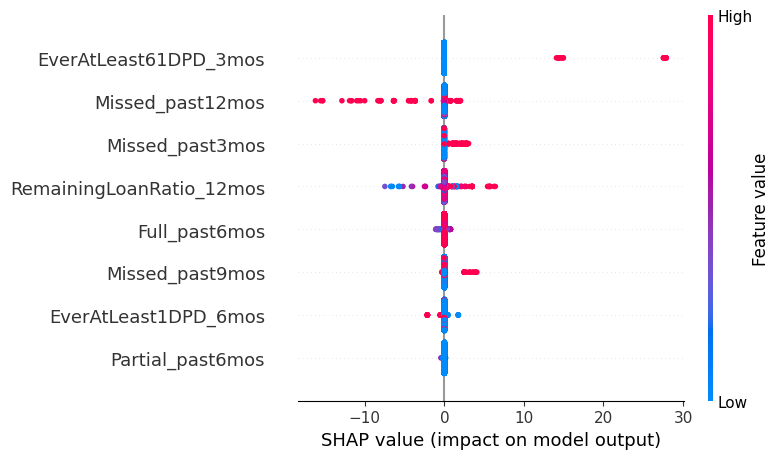

In [95]:
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

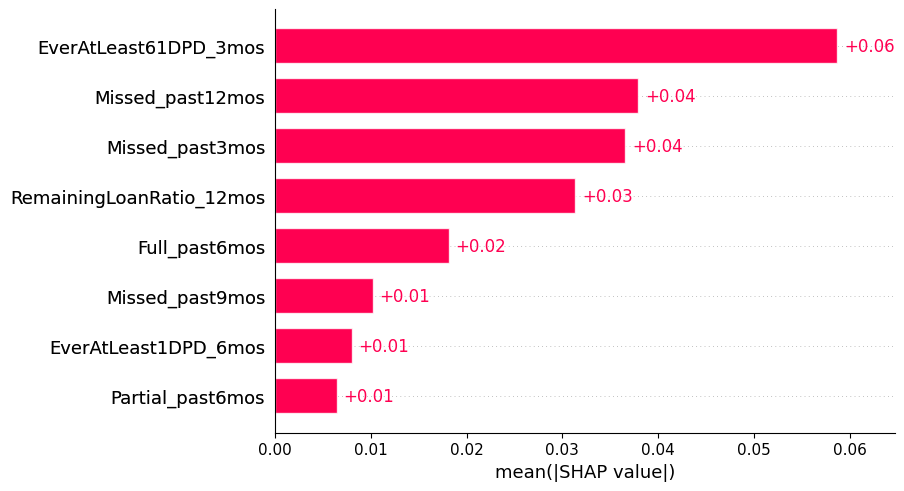

In [96]:
shap.plots.bar(shap_values, max_display=50)

In [97]:
# Step 1: Get mean absolute SHAP values per feature
shap_summary = np.abs(shap_values.values).mean(axis=0)

# Step 2: Create a DataFrame with feature names and their mean SHAP values
shap_df = pd.DataFrame({
    'Feature': shap_values.feature_names,
    'Mean |SHAP value|': shap_summary
})

# Step 3: Sort descending to match what shap.plots.bar shows
shap_df = shap_df.sort_values(by='Mean |SHAP value|', ascending=False)

# Step 4 (Optional): Show top N
top_n = 50
print(shap_df.head(top_n))

                    Feature  Mean |SHAP value|
0     EverAtLeast61DPD_3mos           0.058693
7          Missed_past12mos           0.037906
3           Missed_past3mos           0.036570
2  RemainingLoanRatio_12mos           0.031345
5             Full_past6mos           0.018172
6           Missed_past9mos           0.010238
1      EverAtLeast1DPD_6mos           0.008004
4          Partial_past6mos           0.006439
